In [1]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install folium


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


2019.01~06 중에 언제 지하철을 가장 많이 이용했을까? (기준: 승하차총승객수)

In [2]:
# 1. 필요한 라이브러리 불러오기

import collections
import datetime
import glob
import math
import os
import pathlib
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium


BASE_DIR = pathlib.Path('../').resolve()

pd.options.display.float_format = '{:,}'.format

plt.rcParams['font.family'] ='D2Coding'
plt.rcParams['axes.unicode_minus'] =False

DAY_OF_WEEK = ['월', '화', '수', '목', '금', '토', '일']

palette = sns.color_palette('husl', n_colors=7)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.7757319041862729, 0.5784925270759935, 0.19475566538551875),
 (0.5105309046900421, 0.6614299289084904, 0.1930849118538962),
 (0.20433460114757862, 0.6863857739476534, 0.5407103379425205),
 (0.21662978923073606, 0.6676586160122123, 0.7318695594345369),
 (0.5049017849530067, 0.5909119231215284, 0.9584657252128558),
 (0.9587050080494409, 0.3662259565791742, 0.9231469575614251)]

In [3]:
# 2. 현재 사용가능한 데이터 확인

os.listdir(BASE_DIR / '실습' / 'rawfiles')

['CARD_SUBWAY_MONTH_201903.csv',
 'CARD_SUBWAY_MONTH_201902.csv',
 'CARD_SUBWAY_MONTH_201901.csv',
 'CARD_SUBWAY_MONTH_201905.csv',
 'CARD_SUBWAY_MONTH_201904.csv',
 'CARD_SUBWAY_MONTH_201906.csv',
 '지하철노선위경도정보2.csv']

In [4]:
# 데이터를 병합하여 하나의 데이터프레임 형성

df_raw = pd.DataFrame()

for filename in glob.glob(str(BASE_DIR / '실습' / 'rawfiles' / 'CARD_SUBWAY_MONTH_*.csv')):
    tmp = pd.read_csv(filename)
    df_raw = pd.concat([df_raw, tmp])

df_raw['사용일자'] = pd.to_datetime(df_raw['사용일자'], format='%Y%m%d')
df_raw['주차'] = df_raw['사용일자'].dt.dayofyear // 7 + 1
df_raw['요일'] = df_raw['사용일자'].dt.dayofweek.map({ idx: val for idx, val in enumerate(DAY_OF_WEEK) })
df_raw['연'] = df_raw['사용일자'].dt.year
df_raw['월'] = df_raw['사용일자'].dt.month
df_raw['일'] = df_raw['사용일자'].dt.date
df_raw['승하차총승객수'] = (df_raw['승차총승객수'] + df_raw['하차총승객수']).astype(int)

df_raw.sample(10)

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자,주차,요일,연,월,일,승하차총승객수
11156,2019-06-19,분당선,복정,"13,756.0","11,552.0",20190622,25,수,2019,6,2019-06-19,25308
4117,2019-05-07,9호선,언주,"10,017.0","10,113.0",20190510,19,화,2019,5,2019-05-07,20130
15067,2019-02-26,1호선,아산,"2,906.0","2,656.0",20190301,9,화,2019,2,2019-02-26,5562
11308,2019-03-20,8호선,수진,"6,508.0","6,209.0",20190323,12,수,2019,3,2019-03-20,12717
18052,2019-03-31,1호선,신창,"1,372.0","2,795.0",20190403,13,일,2019,3,2019-03-31,4167
16686,2019-05-29,4호선,서울역,"5,937.0","1,321.0",20190601,22,수,2019,5,2019-05-29,7258
12440,2019-03-22,9호선,둔촌오륜,"1,118.0",946.0,20190325,12,금,2019,3,2019-03-22,2064
3931,2019-04-07,경의선,풍산,"3,890.0","3,627.0",20190410,14,일,2019,4,2019-04-07,7517
5206,2019-01-09,7호선,뚝섬유원지,"7,368.0","7,123.0",20190112,2,수,2019,1,2019-01-09,14491
14825,2019-05-26,2호선,강남,"57,140.0","56,962.0",20190529,21,일,2019,5,2019-05-26,114102


# Q. (특정 역의) 승하차총승객수가 많은 이유?

> ## 가설) 지역의 거주인원 수가 많은건지?

[데이터 전처리]

## 1. 각 역들의 지리상 위치 (지역구) 조사

In [5]:
# 지역구를 추출하자.

df = pd.read_csv(str(BASE_DIR / 'data' / '서울교통공사 역주소 및 전화번호_20240331.csv'))
df['지역구'] = df['도로명주소'].str.extract(r'\s(\w+구)\s')[0].str.strip()

df.head()

,연번,역번호,호선,역명,역전화번호,Unnamed: 5,도로명주소,지번주소,지역구
0,1,150,1,서울,02-6110-1331,NaN,서울특별시 중구 세종대로 지하2(남대문로 5가),서울특별시 중구 남대문로5가 73-6 서울역(1호선),중구
1,2,151,1,시청,02-6110-1321,NaN,서울특별시 중구 세종대로 지하101(정동),서울특별시 중구 정동 5-5 시청역(1호선),중구
2,3,152,1,종각,02-6110-1311,NaN,서울특별시 종로구 종로 지하55(종로1가),서울특별시 종로구 종로1가 54 종각역(1호선),종로구
3,4,153,1,종로3가,02-6110-1301,NaN,서울특별시 종로구 종로 지하129(종로3가),서울특별시 종로구 종로3가 10-5 종로3가역(1호선),종로구
4,5,154,1,종로5가,02-6110-1291,NaN,서울특별시 종로구 종로 지하216(종로5가),서울특별시 종로구 종로5가 82-1 종로5가역(1호선),종로구


In [6]:
# 기존 역 승하차 데이터에 지역구를 추가하자.

df_raw = pd.merge(left=df_raw, right=df[['역명', '지역구']], how='inner', on='역명')
df_raw

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자,주차,요일,연,월,일,승하차총승객수,지역구
0,2019-03-01,1호선,신설동,"1,335.0","1,375.0",20190304,9,금,2019,3,2019-03-01,2710,동대문구
1,2019-03-01,1호선,신설동,"1,335.0","1,375.0",20190304,9,금,2019,3,2019-03-01,2710,동대문구
2,2019-03-01,6호선,보문,"1,208.0","1,271.0",20190304,9,금,2019,3,2019-03-01,2479,성북구
3,2019-03-01,9호선,중앙보훈병원,"3,338.0","2,993.0",20190304,9,금,2019,3,2019-03-01,6331,강동구
4,2019-03-01,9호선,둔촌오륜,521.0,478.0,20190304,9,금,2019,3,2019-03-01,999,강동구
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53941,2019-06-30,4호선,노원,"14,071.0","14,702.0",20190703,26,일,2019,6,2019-06-30,28773,노원구
53942,2019-06-30,7호선,중계,"9,516.0","8,981.0",20190703,26,일,2019,6,2019-06-30,18497,노원구
53943,2019-06-30,7호선,하계,"11,645.0","11,121.0",20190703,26,일,2019,6,2019-06-30,22766,노원구
53944,2019-06-30,6호선,태릉입구,"5,730.0","5,214.0",20190703,26,일,2019,6,2019-06-30,10944,노원구


[데이터 전처리] 

## 2. 지역구 별 등록 인구수 (2019년 1~4월) 조사

In [7]:
df = pd.read_csv(str(BASE_DIR / 'data' / '등록인구_2019.csv'))

df = df[df['동별(2)'] != '소계']
df = df[df['구분별(1)'] == '계 (명)']
df = df[df['구분별(2)'] == '소계']
df['인구수'] = df['데이터'].astype(int)
df['지역구'] = df['동별(2)']
df['연월일'] = pd.to_datetime(df['시점'], format='%Y %m/%d')
df['월'] = df['연월일'].dt.month

df.head()

,시점,동별(1),동별(2),구분별(1),구분별(2),데이터,인구수,지역구,연월일,월
13,2019 1/4,합계,종로구,계 (명),소계,"162,913.0",162913,종로구,2019-01-04,1
25,2019 1/4,합계,중구,계 (명),소계,"135,836.0",135836,중구,2019-01-04,1
37,2019 1/4,합계,용산구,계 (명),소계,"245,139.0",245139,용산구,2019-01-04,1
49,2019 1/4,합계,성동구,계 (명),소계,"314,608.0",314608,성동구,2019-01-04,1
61,2019 1/4,합계,광진구,계 (명),소계,"370,658.0",370658,광진구,2019-01-04,1


In [8]:
df = pd.read_csv(str(BASE_DIR / 'data' / '등록인구_2019.csv'))

df = df[df['동별(2)'] != '소계']
df = df[df['구분별(1)'] == '계 (명)']
df = df[df['구분별(2)'] == '소계']
df['인구수'] = df['데이터'].astype(int)
df['지역구'] = df['동별(2)']
df['연월일'] = pd.to_datetime(df['시점'], format='%Y %m/%d')
df['월'] = df['연월일'].dt.month

df = df.groupby(['지역구', '월'])['인구수'].sum().reset_index()
df = df.groupby(['지역구'])['인구수'].mean().reset_index()
df.head(10)

,지역구,인구수
0,강남구,"548,432.25"
1,강동구,"432,265.0"
2,강북구,"319,024.5"
3,강서구,"600,907.25"
4,관악구,"519,449.0"
5,광진구,"368,859.25"
6,구로구,"439,359.5"
7,금천구,"253,248.25"
8,노원구,"541,305.25"
9,도봉구,"338,078.75"


In [9]:
# 기존 역 승하차 데이터에 지역구를 추가하자.

df_raw = pd.merge(left=df_raw, right=df[['지역구', '인구수']], how='inner', on='지역구')
df_raw.head(10)

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자,주차,요일,연,월,일,승하차총승객수,지역구,인구수
0,2019-03-01,1호선,신설동,"1,335.0","1,375.0",20190304,9,금,2019,3,2019-03-01,2710,동대문구,"363,291.25"
1,2019-03-01,1호선,신설동,"1,335.0","1,375.0",20190304,9,금,2019,3,2019-03-01,2710,동대문구,"363,291.25"
2,2019-03-01,6호선,보문,"1,208.0","1,271.0",20190304,9,금,2019,3,2019-03-01,2479,성북구,"452,792.75"
3,2019-03-01,9호선,중앙보훈병원,"3,338.0","2,993.0",20190304,9,금,2019,3,2019-03-01,6331,강동구,"432,265.0"
4,2019-03-01,9호선,둔촌오륜,521.0,478.0,20190304,9,금,2019,3,2019-03-01,999,강동구,"432,265.0"
5,2019-03-01,9호선,한성백제,"1,344.0","1,071.0",20190304,9,금,2019,3,2019-03-01,2415,송파구,"684,655.25"
6,2019-03-01,9호선,송파나루,"2,858.0","2,762.0",20190304,9,금,2019,3,2019-03-01,5620,송파구,"684,655.25"
7,2019-03-01,8호선,석촌,"4,521.0","2,989.0",20190304,9,금,2019,3,2019-03-01,7510,송파구,"684,655.25"
8,2019-03-01,8호선,석촌,"4,521.0","2,989.0",20190304,9,금,2019,3,2019-03-01,7510,송파구,"684,655.25"
9,2019-03-01,9호선,석촌고분,"3,431.0","3,069.0",20190304,9,금,2019,3,2019-03-01,6500,송파구,"684,655.25"


취합한 데이터로

## "지역별 인구수와 승하차승객수가 관련 있는지 조사"

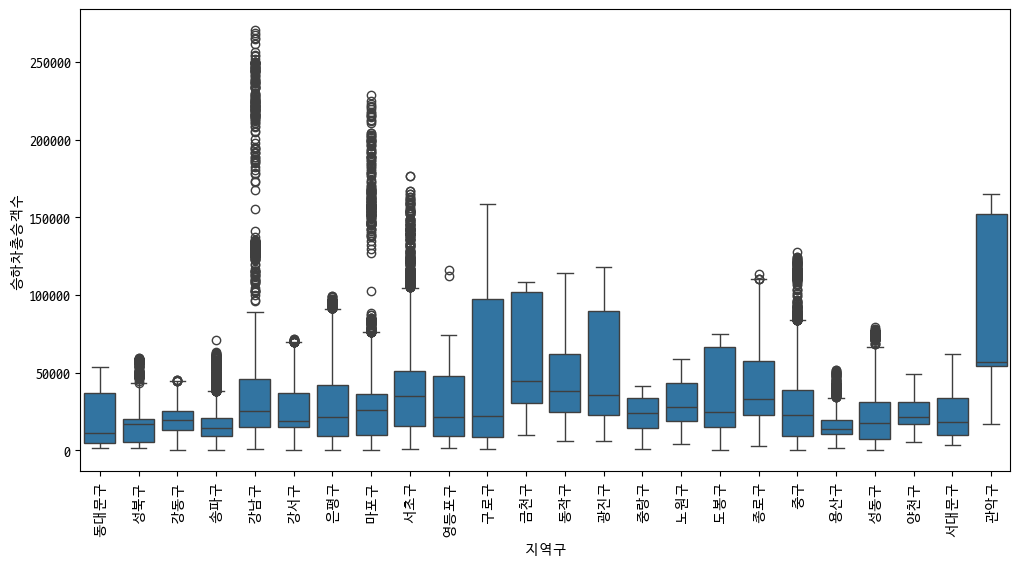

In [10]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=df_raw, x='지역구', y='승하차총승객수')
plt.xticks(rotation=90)
plt.show()

In [11]:
# 지역구 별 승하차총승객수를 구해봅시다.

# 1. 동일한 지역에 있는 역을 하나로 합칩니다. (통계가 집계된 연, 월은 구분)
df = df_raw.groupby(['지역구', '연', '월', '인구수'])['승하차총승객수'].sum().reset_index()

# 2. 동일한 지역에 있는 통계를 연, 월에 대해 평균을 구합니다.
df = df.groupby(['지역구', '인구수'])['승하차총승객수'].median().reset_index()
df = df.sort_values(by=['인구수'], ascending=False)

df.head(10)


,지역구,인구수,승하차총승객수
16,송파구,"684,655.25","16,581,167.5"
2,강서구,"600,907.25","9,087,819.0"
0,강남구,"548,432.25","31,707,688.0"
7,노원구,"541,305.25","14,644,511.0"
3,관악구,"519,449.0","5,827,511.0"
20,은평구,"486,925.75","13,896,263.5"
17,양천구,"464,483.25","2,247,472.5"
15,성북구,"452,792.75","2,515,545.5"
5,구로구,"439,359.5","9,483,118.5"
13,서초구,"435,750.75","16,092,182.0"


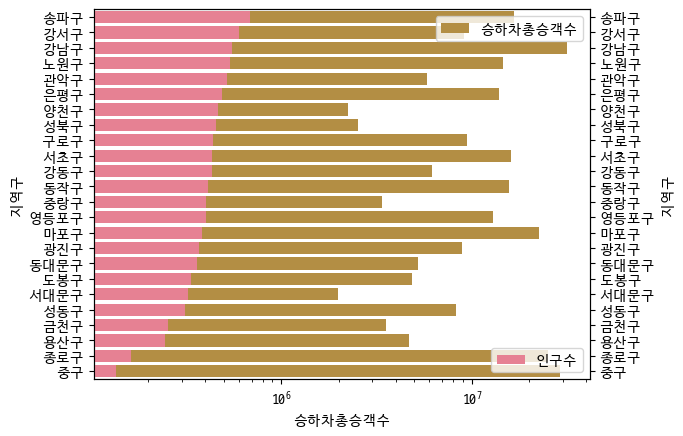

In [12]:
fig, ax = plt.subplots()
sns.barplot(data=df, y='지역구', x='승하차총승객수', label='승하차총승객수', ax=ax, color=palette[1])
ax.legend(loc='upper right')
ax.set_xscale('log')

ax = ax.twinx()
sns.barplot(data=df, y='지역구', x='인구수', label='인구수', color=palette[0], ax=ax)
ax.legend(loc='lower right')

plt.show()

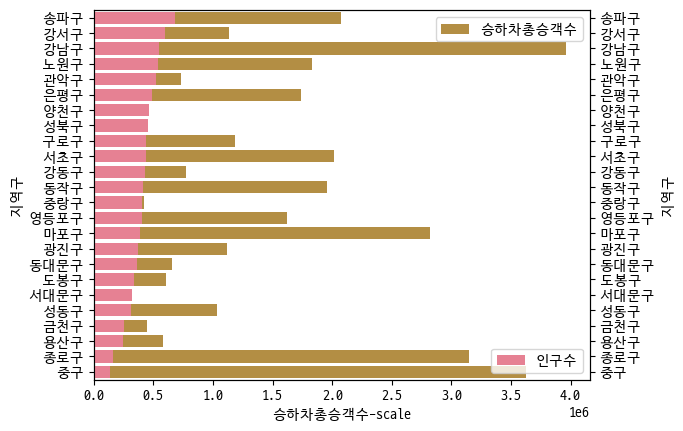

In [13]:
df['승하차총승객수-scale'] = df['승하차총승객수'] / 8

fig, ax = plt.subplots()

sns.barplot(data=df, y='지역구', x='승하차총승객수-scale', label='승하차총승객수', ax=ax, color=palette[1])
ax.legend(loc='upper right')

ax = ax.twinx()
sns.barplot(data=df, y='지역구', x='인구수', label='인구수', color=palette[0], ax=ax)
ax.legend(loc='lower right')

plt.show()

/var/folders/ld/qthvz3k91_1239xs6fkx1zx00000gn/T/ipykernel_47670/2054572301.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
/var/folders/ld/qthvz3k91_1239xs6fkx1zx00000gn/T/ipykernel_47670/2054572301.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


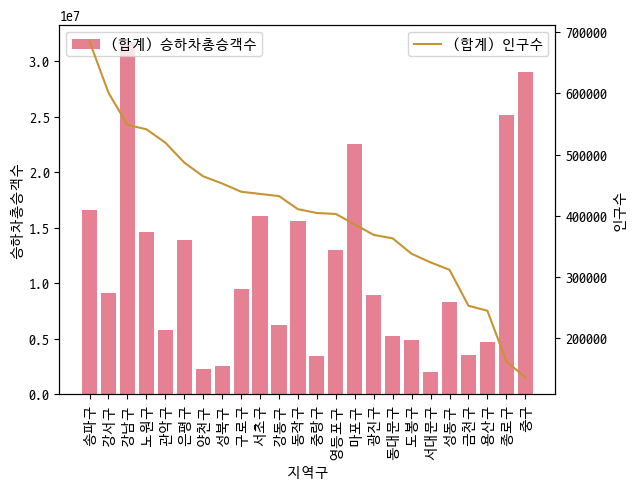

In [14]:
fig, ax = plt.subplots()

sns.barplot(data=df, x='지역구', y='승하차총승객수', ax=ax, color=palette[0], label='(합계) 승하차총승객수')
ax.legend(loc='upper left')

ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)

ax = ax.twinx()  # 두 번째 y축을 만들기 위해 twinx()를 사용한다.
ax.legend(loc='upper right')

sns.lineplot(data=df, x='지역구', y='인구수', ax=ax, color=palette[1], label='(합계) 인구수')

plt.show()

## 결론

* 단순 인구수는 승하차총승객수에 직접적인 연관은 없는 것으로 보인다.
* 인구수보다는 직장같은 유동인구를 유발하는 요인을 봐야할 듯